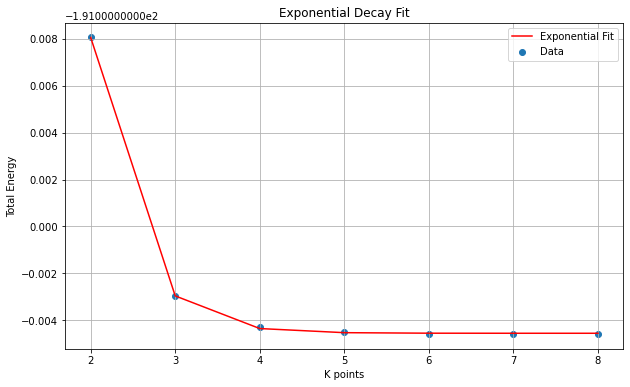

Estimated Energy calculation accuracy: 0.5663468691434077 meV


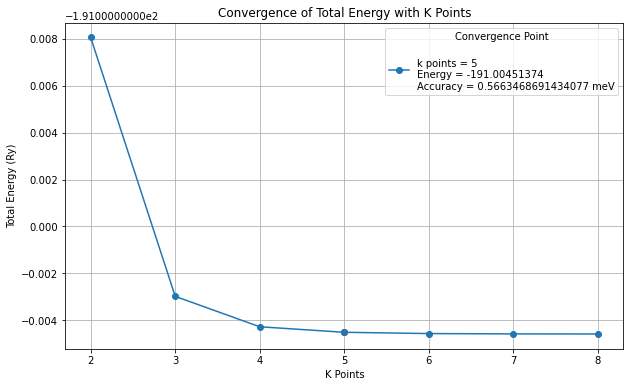

Convergence achieved at k points = 5 with total energy = -191.00451374 Ry.


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model

def read_convergence_data(file_path):
    """Read convergence data from a file."""
    k_points = []
    energy = []
    with open(file_path, 'r') as file:
        #next(file)  # Skip the header line
        for line in file:
            data = line.split()
            k_points.append(int(data[0]))
            energy.append(float(data[1]))
    return np.array(k_points), np.array(energy)

def find_convergence(k_points, energy, threshold=1e-5):
    """Find the convergence point where energy change is below a threshold."""
    energy_diff = np.diff(energy)
    converged_idx = np.where(np.abs(energy_diff) < threshold)[0][0]
    return k_points[converged_idx], energy[converged_idx]

def plot_convergence(k_points, energy, converged_k_points, converged_energy, accuracy):
    """Plot energy as a function of k_points and mark the convergence point."""
    plt.figure(figsize=(10, 6))
    plt.plot(k_points, energy, marker='o', linestyle='-', label='Total Energy')
    
    # Add red marker at the convergence point
    plt.scatter(converged_k_points, converged_energy, color='red', label='Convergence Point')
    
    # Display convergence information in the legend
    legend_text = f'\nk points = {converged_k_points}\nEnergy = {converged_energy}\nAccuracy = {accuracy} meV'
    plt.legend([legend_text], title='Convergence Point', loc='upper right')
    
    plt.xlabel('K Points')
    plt.ylabel('Total Energy (Ry)')
    plt.title('Convergence of Total Energy with K Points')
    plt.grid(True)
    plt.savefig('k_points_convergence_plot.pdf')
    plt.show()
    
def exponential_decay_fit(energy, k_points):
    """
    Fit an exponential decay model to the given data.

    Parameters:
    - energy (array-like): Array-like object containing the total energy values.
    - k_points (array-like): Array-like object containing the k_points values.

    Returns:
    - float: The value of the parameter C, which represents the limit as x approaches infinity in the exponential decay model y = Ae^(-Bx) + C.
    
    This function fits an exponential decay model y = Ae^(-Bx) + C to the provided data using lmfit. It then plots the fit and returns the value of parameter C, which corresponds to the limit of y as x approaches infinity in the model.
    """

    # Define the exponential decay model
    def exp_decay(x, A, B, C):
        return A * np.exp(-B * x) + C

    # Create a model instance
    model = Model(exp_decay)

    # Set initial parameters
    params = model.make_params(A=min(energy), B=1/4, C=min(energy))

    # Perform the fit
    result = model.fit(energy, x=k_points, params=params)

    # Plot the fit
    plt.figure(figsize=(10, 6))
    plt.scatter(k_points, energy, label='Data')
    plt.plot(k_points, result.best_fit, 'r-', label='Exponential Fit')
    plt.xlabel('K points')
    plt.ylabel('Total Energy')
    plt.legend()
    plt.title('Exponential Decay Fit')
    plt.grid()
    plt.savefig('k_points_convergence_plot_fit.pdf')
    plt.show()

    # Return the limit as x approaches infinity (C parameter) #Total Energy at ecut = infinity
    return result.params['C'].value

def ecutwfc_accuracy_estimation(E_converged: float, E_inf: float):
    """
    Calculate the estimated energy calculation accuracy in milli-electron volts (meV).

    Parameters:
    - E_converged (float): The converged energy value obtained from the calculation.
    - E_inf (float): The estimated energy at infinity obtained from a model or fitting.

    Returns:
    - accuracy in meV
    
    This function calculates the estimated energy calculation accuracy in milli-electron volts (meV) based on the difference between the converged energy value and the estimated energy at infinity.
    """

    accuracy_Ry = E_converged - E_inf #accuracy in Rydberg
    accuracy_eV = accuracy_Ry * 13.6057
    accuracy_meV = accuracy_eV*1000 # accuracy in meV
    print(f"Estimated Energy calculation accuracy: {accuracy_meV} meV")
    
    return accuracy_meV

if __name__ == "__main__":
    # Read convergence data
    k_points, energy = read_convergence_data('convergence_data_kpoints.txt')

    # Find convergence point
    converged_k_points, converged_energy = find_convergence(k_points, energy, threshold=1e-4)
    
    # Fit the convergence data to predict the Total energy at k points = Infinity.
    E_inf = exponential_decay_fit(energy, k_points)
    
    #Estimate the accuracy of the convergence
    accuracy = ecutwfc_accuracy_estimation(converged_energy, E_inf)
    
    # Plot convergence
    plot_convergence(k_points, energy, converged_k_points, converged_energy, accuracy)

    print(f"Convergence achieved at k points = {converged_k_points} with total energy = {converged_energy} Ry.")
